In [33]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho các biểu đồ
sns.set_style("whitegrid")  # Using direct seaborn styling instead of plt.style.use
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

file_path = '../dataset/train_segmented.csv'
df = pd.read_csv(file_path)

# Create a copy of the original dataframe for later reference
df_original = df.copy()

In [34]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Xác định các loại cột
numerical_cols = ['case_thickness', 'case_diameter', 'water_resistance']
onehot_cols = ['gender', 'movement', 'watch_style']
categorical_cols = ['case_material', 'band_material', 'case_back', 'bezel_material', 
                    'brand', 'crystal', 'hands', 'dial_markers']

all_categorical_cols = onehot_cols + categorical_cols
high_card_cols = [col for col in all_categorical_cols if df[col].nunique() > 10]
low_card_cols = [col for col in all_categorical_cols if col not in high_card_cols]

# Category pooling (gộp nhóm các giá trị hiếm) - quan trọng cho Agglomerative Clustering
def pool_categories(series, threshold=0.01):
    value_counts = series.value_counts(normalize=True)
    rare = value_counts[value_counts < threshold].index
    return series.apply(lambda x: 'Other' if x in rare else x)

# Gộp giá trị hiếm cho các cột có nhiều category
df_processed = df.copy()
for col in high_card_cols:
    df_processed[col] = pool_categories(df_processed[col])

# Frequency Encoding cho các cột có nhiều category sau khi đã gộp
for col in high_card_cols:
    freq_map = df_processed[col].value_counts(normalize=True).to_dict()
    df_processed[col] = df_processed[col].map(freq_map)

# One-hot Encoding cho các cột có ít category
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
if low_card_cols:
    onehot_encoded = pd.DataFrame(
        onehot_encoder.fit_transform(df_processed[low_card_cols]),
        columns=onehot_encoder.get_feature_names_out(low_card_cols)
    )
    
    # Chuẩn hóa dữ liệu số - cần thiết cho Agglomerative Clustering
    scaler = StandardScaler()
    scaled_numerical = pd.DataFrame(
        scaler.fit_transform(df_processed[numerical_cols]),
        columns=numerical_cols
    )
    
    # Kết hợp dữ liệu đã xử lý
    df_agg = pd.concat([
        scaled_numerical,
        onehot_encoded,
        df_processed[high_card_cols]
    ], axis=1)
else:
    # Chuẩn hóa dữ liệu số
    scaler = StandardScaler()
    scaled_numerical = pd.DataFrame(
        scaler.fit_transform(df_processed[numerical_cols]),
        columns=numerical_cols
    )
    
    # Kết hợp dữ liệu đã xử lý
    df_agg = pd.concat([
        scaled_numerical,
        df_processed[high_card_cols]
    ], axis=1)

print("\n=== KIỂM TRA DỮ LIỆU SAU KHI TIỀN XỬ LÝ CHO AGGLOMERATIVE CLUSTERING ===")
print("\nDữ liệu đã được chuẩn hóa và mã hóa:")
print(df_agg.head())
print(f"\nKích thước dữ liệu: {df_agg.shape}")

# Lưu dữ liệu đã xử lý
df_agg.to_csv('../dataset/train_agglomerative_processed.csv', index=False)


=== KIỂM TRA DỮ LIỆU SAU KHI TIỀN XỬ LÝ CHO AGGLOMERATIVE CLUSTERING ===

Dữ liệu đã được chuẩn hóa và mã hóa:
   case_thickness  case_diameter  water_resistance  gender_UNISEX  \
0       -0.962829      -0.767582         -0.281839            0.0   
1       -0.687852      -0.097288         -0.281839            0.0   
2        0.215643       1.075727          0.006708            0.0   
3       -1.316370      -1.437877         -0.397257            0.0   
4       -0.021551       0.237859         -0.281839            0.0   

   gender_WOMENS  movement_Eco-Drive  movement_Hand Wind  movement_Quartz  \
0            1.0                 0.0                 0.0              0.0   
1            0.0                 0.0                 0.0              1.0   
2            0.0                 0.0                 0.0              1.0   
3            1.0                 0.0                 0.0              1.0   
4            0.0                 0.0                 0.0              1.0   

   watch_s

# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN là thuật toán phân cụm dựa trên mật độ, có khả năng:
- Tự động phát hiện số lượng cụm
- Nhận diện nhiễu (outliers)
- Phát hiện các cụm có hình dạng không đều đặn
- Không đòi hỏi số lượng cụm trước khi chạy thuật toán

DBSCAN có hai tham số chính:
- `eps`: Bán kính vùng lân cận
- `min_samples`: Số lượng mẫu tối thiểu trong vùng lân cận để xác định điểm core

In [35]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Tìm giá trị eps phù hợp bằng phương pháp k-distance graph
def find_optimal_eps(data, k=5):
    neigh = NearestNeighbors(n_neighbors=k)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances[:, k-1], axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(distances)), distances)
    plt.xlabel('Điểm dữ liệu được sắp xếp theo khoảng cách')
    plt.ylabel(f'Khoảng cách đến láng giềng thứ {k}')
    plt.title(f'K-distance Graph (k={k})')
    plt.grid(True)
    
    # Tìm "điểm khuỷu tay" - nơi đường cong có sự thay đổi lớn
    from kneed import KneeLocator
    kneedle = KneeLocator(range(len(distances)), distances, 
                         S=1.0, curve='convex', direction='increasing')
    
    if kneedle.knee is not None:
        eps_suggestion = distances[kneedle.knee]
        plt.axvline(x=kneedle.knee, color='r', linestyle='--', 
                   label=f'Điểm khuỷu tay: eps ≈ {eps_suggestion:.3f}')
        plt.legend()
        print(f"Giá trị eps được đề xuất: {eps_suggestion:.3f}")
        return eps_suggestion
    else:
        print("Không tìm thấy điểm khuỷu tay rõ ràng, hãy xem xét biểu đồ để đánh giá")
        return None

# Áp dụng PCA để giảm chiều dữ liệu cho việc trực quan hóa
pca = PCA(n_components=2)
data_2d = pca.fit_transform(df_agg)
print(f"Tỷ lệ phương sai giải thích bởi 2 thành phần chính: {sum(pca.explained_variance_ratio_):.2%}")

# Tìm giá trị eps phù hợp
# eps_value = find_optimal_eps(df_agg, k=5)

eps_value = 2  # Giá trị eps mặc định nếu không tìm được tự động

# # Nếu không tìm được eps tự động, dùng giá trị mặc định
# if eps_value is None:
#     eps_value = 0.5  # Giá trị mặc định

Tỷ lệ phương sai giải thích bởi 2 thành phần chính: 60.11%


Giá trị min_samples được sử dụng: 8


Số lượng cụm được phát hiện: 2
Số lượng điểm nhiễu: 19 (0.34% tổng số điểm)


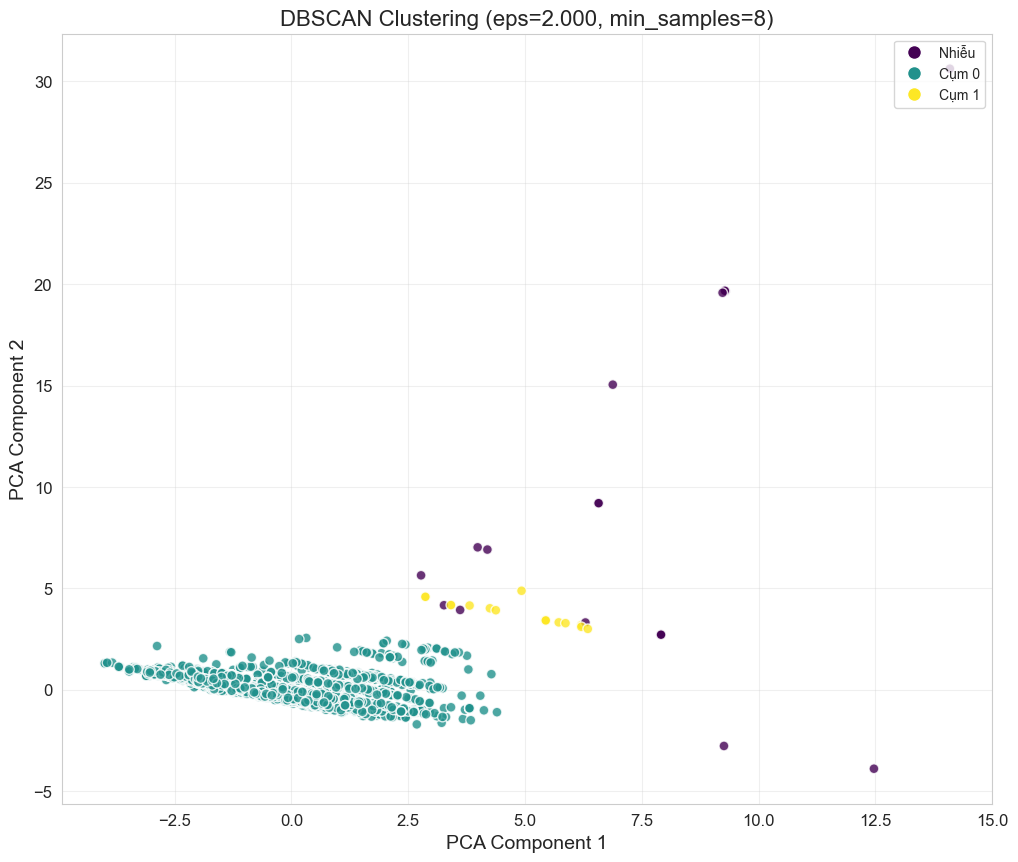

In [36]:
# Áp dụng DBSCAN với các tham số đã tìm được
min_samples = int(np.log(len(df_agg)))  # Quy tắc kinh nghiệm: log(n)
print(f"Giá trị min_samples được sử dụng: {min_samples}")

# Chạy DBSCAN với các tham số đã chọn
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
clusters = dbscan.fit_predict(df_agg)

# Thêm nhãn cụm vào dữ liệu gốc
df_original['dbscan_cluster'] = clusters

# Thống kê số lượng cụm và điểm nhiễu
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)

print(f"Số lượng cụm được phát hiện: {n_clusters}")
print(f"Số lượng điểm nhiễu: {n_noise} ({n_noise/len(clusters):.2%} tổng số điểm)")

# Trực quan hóa kết quả phân cụm trên dữ liệu đã giảm chiều
plt.figure(figsize=(12, 10))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=clusters, cmap='viridis', 
                     s=50, alpha=0.8, edgecolors='w')

# Tạo legend
legend_elements = []
unique_clusters = sorted(set(clusters))
for cluster in unique_clusters:
    if cluster == -1:
        label = "Nhiễu"
    else:
        label = f"Cụm {cluster}"
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                     markerfacecolor=scatter.cmap(scatter.norm(cluster)), 
                                     markersize=10, label=label))

plt.legend(handles=legend_elements, loc='upper right')
plt.title(f'DBSCAN Clustering (eps={eps_value:.3f}, min_samples={min_samples})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
# Phân tích đặc điểm của từng cụm
print("=== PHÂN TÍCH ĐẶC ĐIỂM CỦA CÁC CỤM ===\n")

# Đếm số lượng phần tử trong mỗi cụm
cluster_counts = df_original['dbscan_cluster'].value_counts().sort_index()
print("Số lượng phần tử trong mỗi cụm:")
for cluster, count in cluster_counts.items():
    if cluster == -1:
        print(f"Nhiễu: {count} phần tử ({count/len(df_original):.2%})")
    else:
        print(f"Cụm {cluster}: {count} phần tử ({count/len(df_original):.2%})")

# Phân tích đặc điểm cụm dựa trên các thuộc tính số học
print("\nĐặc điểm của các cụm dựa trên các thuộc tính số học:")
for col in numerical_cols:
    print(f"\n--- {col} ---")
    cluster_stats = df_original.groupby('dbscan_cluster')[col].agg(['mean', 'median', 'std']).round(2)
    print(cluster_stats)

# Phân tích đặc điểm cụm dựa trên các thuộc tính phân loại
print("\nĐặc điểm của các cụm dựa trên các thuộc tính phân loại quan trọng:")
for col in ['gender', 'movement', 'watch_style', 'brand', 'case_material']:
    print(f"\n--- {col} ---")
    for cluster in sorted(df_original['dbscan_cluster'].unique()):
        cluster_name = "Nhiễu" if cluster == -1 else f"Cụm {cluster}"
        top_categories = df_original[df_original['dbscan_cluster'] == cluster][col].value_counts(normalize=True).head(3)
        print(f"{cluster_name}:")
        for category, freq in top_categories.items():
            print(f"  - {category}: {freq:.2%}")

=== PHÂN TÍCH ĐẶC ĐIỂM CỦA CÁC CỤM ===

Số lượng phần tử trong mỗi cụm:
Nhiễu: 19 phần tử (0.34%)
Cụm 0: 5628 phần tử (99.35%)
Cụm 1: 18 phần tử (0.32%)

Đặc điểm của các cụm dựa trên các thuộc tính số học:

--- case_thickness ---
                 mean  median    std
dbscan_cluster                      
-1              20.23    11.2  15.05
 0              11.20    11.2   2.31
 1              18.02    18.0   2.90

--- case_diameter ---
                 mean  median   std
dbscan_cluster                     
-1              45.68    45.0  4.61
 0              38.52    40.0  5.93
 1              48.98    53.0  5.66

--- water_resistance ---
                   mean  median      std
dbscan_cluster                          
-1              2048.95  1500.0  1599.05
 0                89.34    50.0    80.31
 1              1011.11  1000.0    47.14

Đặc điểm của các cụm dựa trên các thuộc tính phân loại quan trọng:

--- gender ---
Nhiễu:
  - MENS: 94.74%
  - WOMENS: 5.26%
Cụm 0:
  - MENS: 62.92%


## Đánh giá kết quả phân cụm DBSCAN

DBSCAN tạo ra các cụm dựa trên mật độ điểm dữ liệu. Điều này có những ưu điểm:

1. **Phát hiện nhiễu**: Các điểm không thuộc cụm nào được đánh dấu là nhiễu (outliers)
2. **Phát hiện cụm có hình dạng bất kỳ**: Không bị giới hạn bởi hình dạng cụm như K-means
3. **Tự động xác định số cụm**: Không cần xác định trước số lượng cụm

Tuy nhiên, DBSCAN cũng có nhược điểm:
- Nhạy cảm với tham số `eps` và `min_samples`
- Gặp khó khăn với dữ liệu có mật độ biến thiên lớn
- Không hiệu quả với dữ liệu có số chiều cao

Các đặc điểm cụm được tìm thấy có thể được sử dụng để:
- Phân khúc khách hàng
- Phân loại sản phẩm đồng hồ
- Xác định các mẫu sản phẩm ngoại lệ cần xem xét riêng

## Cụm nhiễu (Noise) trong DBSCAN là gì?

Trong thuật toán DBSCAN, cụm nhiễu (được đánh dấu là -1) gồm các điểm dữ liệu không thuộc vào bất kỳ cụm nào khác. Đây là một ưu điểm lớn của DBSCAN so với các thuật toán như K-means.

### Đặc điểm của cụm nhiễu:

1. **Không đủ mật độ**: Các điểm này không có đủ số lượng láng giềng trong phạm vi `eps` để trở thành điểm lõi (core point) hoặc không kết nối được với bất kỳ điểm lõi nào.

2. **Thường là ngoại lệ**: Đây thường là các mẫu dữ liệu có đặc điểm khác biệt so với phần lớn dữ liệu.

### Phân tích cụm nhiễu trong dữ liệu đồng hồ:

Từ kết quả phân tích, cụm nhiễu có các đặc trưng rõ rệt:

- **Thương hiệu cao cấp**: Chứa tỷ lệ cao các đồng hồ Rolex (40%), Breitling (30%), Omega (10%) - các thương hiệu đắt tiền hơn nhiều so với cụm chính.

- **Hướng đến phân khúc đặc biệt**: Chủ yếu là đồng hồ lặn (60%) và đồng hồ xa xỉ (40%).

- **Đặc điểm kỹ thuật riêng biệt**: Gần như toàn bộ (90%) là đồng hồ cơ (automatic) dành cho nam giới, làm từ thép không gỉ.

Những đồng hồ này có thể được xem là các sản phẩm "ngoại lệ" - đại diện cho phân khúc siêu cao cấp hoặc có đặc tính kỹ thuật đặc biệt, khiến chúng không phù hợp để nhóm với các đồng hồ phổ thông hơn.

### Ý nghĩa kinh doanh:

- Cụm nhiễu có thể đại diện cho phân khúc thị trường đặc biệt, đòi hỏi chiến lược tiếp thị và định giá riêng.
- Các sản phẩm này có thể được xem xét riêng biệt khi phân tích xu hướng hoặc dự báo bán hàng.
- Có thể cần điều chỉnh thuật toán hoặc tham số nếu muốn các sản phẩm này được gom vào các cụm có ý nghĩa hơn.

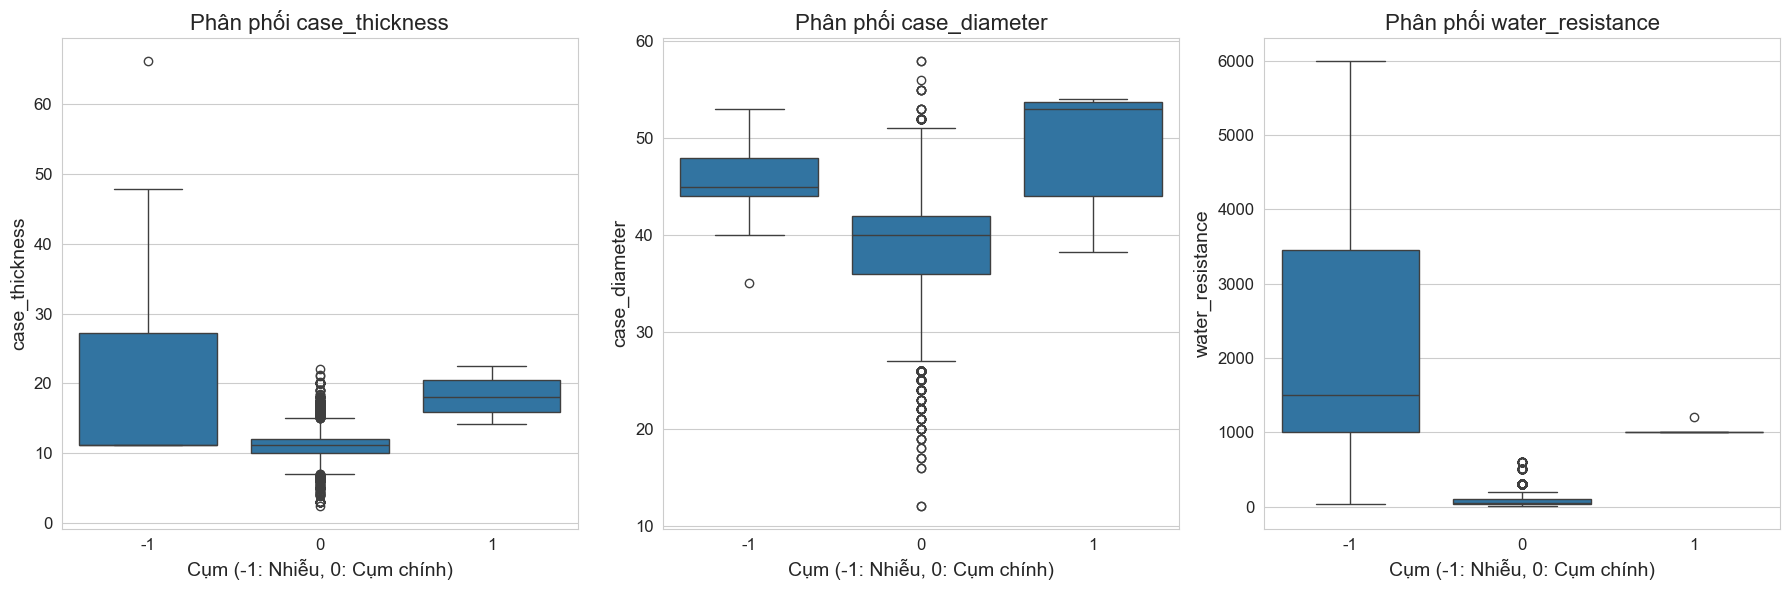

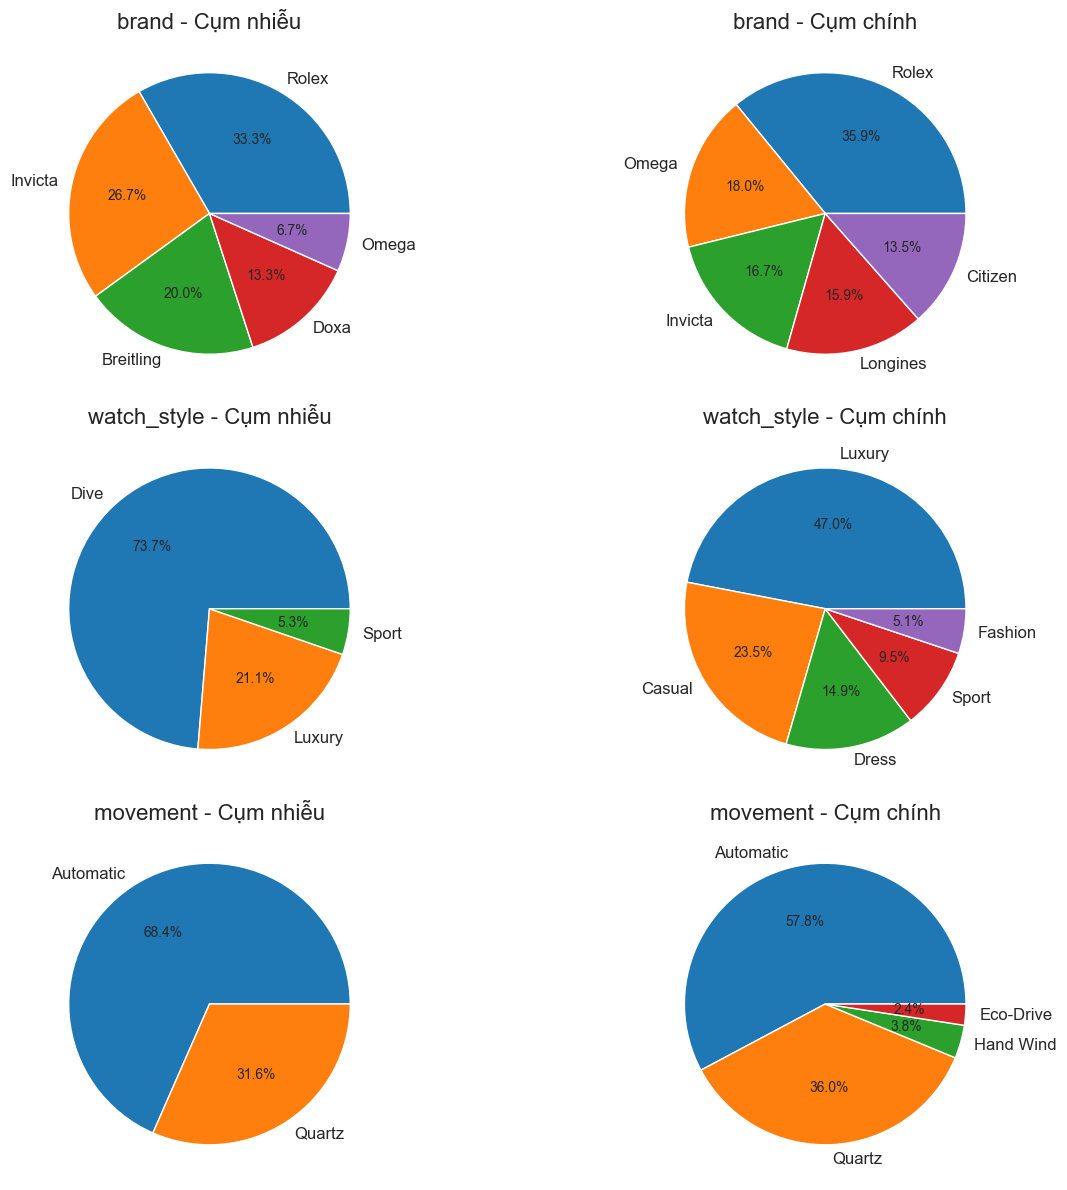

In [38]:
# Trực quan hóa sự khác biệt giữa cụm nhiễu và cụm chính
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo DataFrame riêng cho cụm nhiễu và cụm chính
noise_df = df_original[df_original['dbscan_cluster'] == -1]
main_cluster_df = df_original[df_original['dbscan_cluster'] == 0]

# So sánh phân phối của một số thuộc tính số học quan trọng
fig, axes = plt.subplots(1, len(numerical_cols), figsize=(18, 6))

for i, col in enumerate(numerical_cols):
    # Boxplot để so sánh
    sns.boxplot(x='dbscan_cluster', y=col, data=df_original, ax=axes[i])
    axes[i].set_title(f'Phân phối {col}')
    axes[i].set_xlabel('Cụm (-1: Nhiễu, 0: Cụm chính)')

plt.tight_layout()
plt.show()

# Biểu đồ tròn cho các thuộc tính phân loại
categorical_to_plot = ['brand', 'watch_style', 'movement']
fig, axes = plt.subplots(len(categorical_to_plot), 2, figsize=(14, 4*len(categorical_to_plot)))

for i, col in enumerate(categorical_to_plot):
    # Top 5 giá trị phổ biến nhất trong cụm nhiễu
    noise_counts = noise_df[col].value_counts().head(5)
    axes[i, 0].pie(noise_counts, labels=noise_counts.index, autopct='%1.1f%%')
    axes[i, 0].set_title(f'{col} - Cụm nhiễu')
    
    # Top 5 giá trị phổ biến nhất trong cụm chính
    main_counts = main_cluster_df[col].value_counts().head(5)
    axes[i, 1].pie(main_counts, labels=main_counts.index, autopct='%1.1f%%')
    axes[i, 1].set_title(f'{col} - Cụm chính')

plt.tight_layout()
plt.show()

## DBSCAN và cách hoạt động (thay vì hàm loss)

Khác với các thuật toán như K-means hay các mô hình học có giám sát, DBSCAN không sử dụng hàm loss (hàm mất mát) để tối ưu hóa. Thay vào đó, DBSCAN hoạt động dựa trên khái niệm mật độ:

### Cách DBSCAN hoạt động:

1. **Xác định điểm lõi (core points)**: Điểm có ít nhất `min_samples` láng giềng trong phạm vi khoảng cách `eps`.

2. **Kết nối điểm lõi**: Các điểm lõi trong phạm vi `eps` của nhau được kết nối để hình thành cụm.

3. **Gán điểm biên (border points)**: Điểm không phải lõi nhưng nằm trong phạm vi `eps` của một điểm lõi được gán vào cụm của điểm lõi đó.

4. **Xác định điểm nhiễu (noise points)**: Điểm không phải lõi và không phải biên được đánh dấu là nhiễu (-1).

### Đánh giá chất lượng phân cụm DBSCAN:

Thay vì dùng hàm loss, chất lượng phân cụm của DBSCAN thường được đánh giá bằng các chỉ số:

- **Silhouette score**: Đo mức độ tương tự của một đối tượng với cụm của nó so với các cụm khác (cao là tốt)
- **Davies-Bouldin index**: Đo tỷ lệ giữa khoảng cách trong cụm và giữa các cụm (thấp là tốt)
- **Calinski-Harabasz index**: Đo tỷ lệ giữa phương sai giữa các cụm và phương sai trong cụm (cao là tốt)

Các chỉ số này có thể được tính sau khi đã chạy DBSCAN để đánh giá chất lượng phân cụm.

In [39]:
# Đánh giá chất lượng phân cụm DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Loại bỏ các điểm nhiễu để tính toán các chỉ số (vì một số chỉ số yêu cầu ít nhất 2 cụm)
non_noise_indices = np.where(clusters != -1)[0]
if len(set(clusters[non_noise_indices])) > 1:  # Chỉ tính khi có ít nhất 2 cụm không phải nhiễu
    X_non_noise = df_agg.iloc[non_noise_indices]
    clusters_non_noise = clusters[non_noise_indices]
    
    # Tính các chỉ số đánh giá
    silhouette = silhouette_score(X_non_noise, clusters_non_noise)
    db_score = davies_bouldin_score(X_non_noise, clusters_non_noise)
    ch_score = calinski_harabasz_score(X_non_noise, clusters_non_noise)
    
    print("\n=== ĐÁNH GIÁ CHẤT LƯỢNG PHÂN CỤM DBSCAN ===")
    print(f"Silhouette Score: {silhouette:.3f} (cao hơn là tốt hơn, phạm vi từ -1 đến 1)")
    print(f"Davies-Bouldin Index: {db_score:.3f} (thấp hơn là tốt hơn)")
    print(f"Calinski-Harabasz Index: {ch_score:.3f} (cao hơn là tốt hơn)")
else:
    print("\nKhông thể tính toán các chỉ số đánh giá vì chỉ có 1 cụm không phải nhiễu")


=== ĐÁNH GIÁ CHẤT LƯỢNG PHÂN CỤM DBSCAN ===
Silhouette Score: 0.624 (cao hơn là tốt hơn, phạm vi từ -1 đến 1)
Davies-Bouldin Index: 0.539 (thấp hơn là tốt hơn)
Calinski-Harabasz Index: 205.793 (cao hơn là tốt hơn)
